# Practical 2

## Download a smaller MovieLens dataset to develop and debug with, and again index it

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
import csv
import numpy as np

# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
indexed_user_ids = []
indexed_movie_ids = []
ratings = []

# Load data from CSV file
with open('./ml-latest-small/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])

        # Map user_id to a new zero-based index
        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        # Map movie_id to a new zero-based index
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        # Use the mapped indices for storing data
        indexed_user_ids.append(user_to_index[user_id])
        indexed_movie_ids.append(movie_to_index[movie_id])
        ratings.append(rating)

# Convert lists to numpy arrays
indexed_user_ids = np.array(indexed_user_ids)
indexed_movie_ids = np.array(indexed_movie_ids)
ratings = np.array(ratings)


In [3]:
print("Number of entries in array:", len(ratings))
print("Number of elements in indexed_user_ids:", len(indexed_user_ids))
print("Number of elements in indexd_movie_ids:", len(indexed_movie_ids))

Number of entries in array: 100836
Number of elements in indexed_user_ids: 100836
Number of elements in indexd_movie_ids: 100836


## Build a model that finds Maximum Likelihood Estimate for user + item biases with alternating least squares

In [4]:
def calculate_rmse(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias):
    squared_errors = []
    for i, user_id in enumerate(np.unique(user_ids)):
        indices = np.where(user_ids == user_id)[0]
        movie_ids_subset = movie_ids[indices]
        ratings_subset = ratings[indices]
        predicted_ratings = global_bias + user_bias[i] + item_bias[movie_ids_subset]
        squared_errors.extend((ratings_subset - predicted_ratings) ** 2)
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse

def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg):
    total_loss = 0
    for i, user_id in enumerate(np.unique(user_ids)):
        indices = np.where(user_ids == user_id)[0]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[movie_ids[indices]]
        predicted_ratings = global_bias + user_bias[i] + item_bias_subset
        squared_errors = (ratings_subset - predicted_ratings) ** 2
        total_loss += np.sum(squared_errors)
    total_loss += lambda_reg * (np.sum(user_bias ** 2) + np.sum(item_bias ** 2))
    return total_loss

In [5]:
import numpy as np

def initialize_biases(user_ids, movie_ids, ratings):
    global_bias = np.mean(ratings)
    unique_users = np.unique(user_ids)
    unique_movies = np.unique(movie_ids)
    user_bias = np.zeros(len(unique_users))
    item_bias = np.zeros(len(unique_movies))
    return user_bias, item_bias, global_bias

def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg):
    for i, user_id in enumerate(np.unique(user_ids)):
        indices = np.where(user_ids == user_id)[0]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[movie_ids[indices]]
        user_bias[i] = (np.mean(ratings_subset - global_bias - item_bias_subset)) - lambda_reg * user_bias[i]
    return user_bias

def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg):
    for j, movie_id in enumerate(np.unique(movie_ids)):
        indices = np.where(movie_ids == movie_id)[0]
        ratings_subset = ratings[indices]
        user_bias_subset = user_bias[user_ids[indices]]
        item_bias[j] = (np.mean(ratings_subset - global_bias - user_bias_subset)) - lambda_reg * item_bias[j]
    return item_bias


def alternating_least_squares(user_ids, movie_ids, ratings, iterations=10, lambda_reg=0.1):
    user_bias, item_bias, global_bias = initialize_biases(user_ids, movie_ids, ratings)
    rmses = []
    losses = []
    for iteration in range(iterations):
        user_bias = update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg)
        item_bias = update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg)
        rmse = calculate_rmse(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias)
        loss = calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg)
        rmses.append(rmse)
        losses.append(loss)
        print(f"Iteration {iteration + 1}, Loss: {loss}, RMSE: {rmse}")
    return user_bias, item_bias, global_bias, rmses, losses

# Execute the algorithm
lambda_reg = 0.1
user_bias, item_bias, global_bias, rmses, losses = alternating_least_squares(indexed_user_ids, indexed_movie_ids, ratings, 10, lambda_reg)


Iteration 1, Loss: 65797.12323967107, RMSE: 0.8042355216463907
Iteration 2, Loss: 63271.66535957066, RMSE: 0.7885865387909751
Iteration 3, Loss: 63235.17970980298, RMSE: 0.7882883967389832
Iteration 4, Loss: 63234.1947681809, RMSE: 0.7882869477656621
Iteration 5, Loss: 63233.63536785477, RMSE: 0.7882826850765697
Iteration 6, Loss: 63233.51534537998, RMSE: 0.788281784544239
Iteration 7, Loss: 63233.48778694883, RMSE: 0.7882815527356273
Iteration 8, Loss: 63233.48127161797, RMSE: 0.7882814988619422
Iteration 9, Loss: 63233.479554894344, RMSE: 0.7882814846750479
Iteration 10, Loss: 63233.479127824554, RMSE: 0.788281481136979


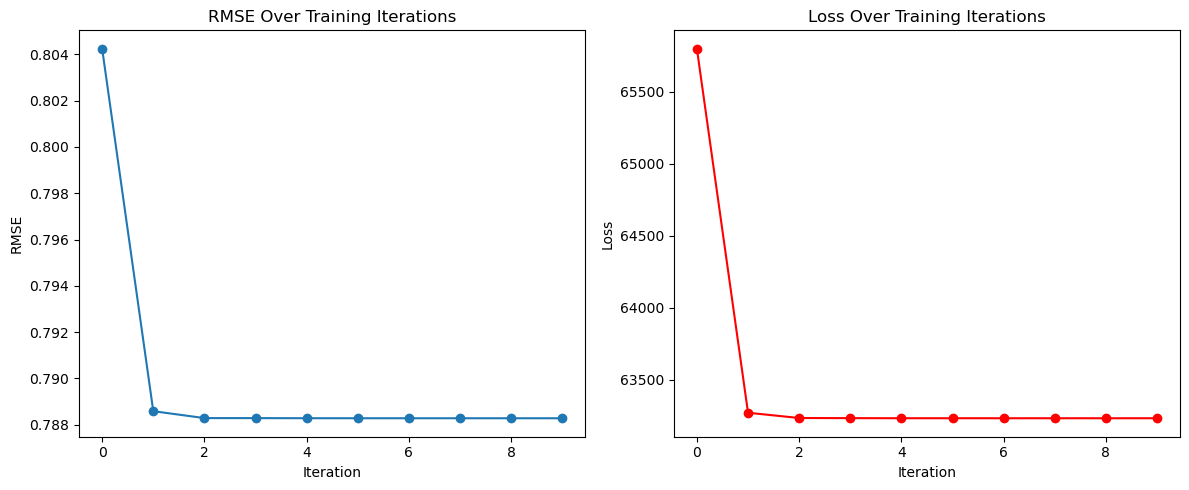

In [6]:
# Plotting the RMSE over iterations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rmses, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Training Iterations')

# Plotting the Loss over iterations
plt.subplot(1, 2, 2)
plt.plot(losses, marker='o', linestyle='-', color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Training Iterations')

plt.tight_layout()
plt.show()

## Testing a simple prediction

In [7]:
def predict_rating(user_id, movie_id, user_bias, item_bias, global_bias, user_index, movie_index):
    user_idx = user_index[user_id]
    movie_idx = movie_index[movie_id]
    return global_bias + user_bias[user_idx] + item_bias[movie_idx]

# Example prediction
some_user_id = 610
some_movie_id = 4054
predicted = predict_rating(some_user_id, some_movie_id, user_bias, item_bias, global_bias, indexed_user_ids, indexed_movie_ids)
print("Predicted Rating:", predicted)

Predicted Rating: 3.3044468573874672


## Professor's solution

In [8]:
def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma):
    predictions = global_bias + user_bias[user_ids] + item_bias[movie_ids]
    errors = ratings - predictions
    return -0.5 * lambda_reg * np.sum(errors**2) - 0.5 * gamma * (np.sum(user_bias**2) + np.sum(item_bias**2))

def calculate_rmse(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias):
    predictions = global_bias + user_bias[user_ids] + item_bias[movie_ids]
    errors = ratings - predictions
    mse = np.mean(errors**2)
    return np.sqrt(mse)

def initialize_biases(user_ids, movie_ids, ratings):
    global_bias = np.mean(ratings)
    unique_users = np.unique(user_ids)
    unique_movies = np.unique(movie_ids)
    user_bias = np.zeros(len(unique_users))
    item_bias = np.zeros(len(unique_movies))
    return user_bias, item_bias, global_bias

In [9]:
import numpy as np

def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma):
    for i, user_id in enumerate(np.unique(user_ids)):
        indices = np.where(user_ids == user_id)[0]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[movie_ids[indices]]
        # Apply the lambda scaling to the error term and include regularization
        user_bias[i] = (np.sum(lambda_reg * (ratings_subset - (global_bias + item_bias_subset))) /
                        (lambda_reg * len(indices) + gamma))
    return user_bias

def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma):
    for j, movie_id in enumerate(np.unique(movie_ids)):
        indices = np.where(movie_ids == movie_id)[0]
        ratings_subset = ratings[indices]
        user_bias_subset = user_bias[user_ids[indices]]
        # Apply the lambda scaling to the error term and include regularization
        item_bias[j] = (np.sum(lambda_reg * (ratings_subset - (global_bias + user_bias_subset))) /
                        (lambda_reg * len(indices) + gamma))
    return item_bias

def alternating_least_squares(user_ids, movie_ids, ratings, iterations=10, lambda_reg=1.0, gamma=0.1):
    user_bias, item_bias, global_bias = initialize_biases(user_ids, movie_ids, ratings)
    rmses = []
    losses = []
    for iteration in range(iterations):
        user_bias = update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma)
        item_bias = update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma)
        loss = calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias, lambda_reg, gamma)
        rmse = calculate_rmse(user_ids, movie_ids, ratings, user_bias, item_bias, global_bias)
        losses.append(loss)
        rmses.append(rmse)
        print(f"Iteration {iteration + 1}, Loss: {loss}, RMSE: {rmse}")
    return user_bias, item_bias, global_bias, losses, rmses

Iteration 1, Loss: -3287.8137678849494, RMSE: 0.8044139218629459
Iteration 2, Loss: -3154.7727552650426, RMSE: 0.7873728975186627
Iteration 3, Loss: -3145.871551279135, RMSE: 0.7860959328113527
Iteration 4, Loss: -3145.070861635558, RMSE: 0.7859496336885614
Iteration 5, Loss: -3144.9568474379494, RMSE: 0.7859231380767955
Iteration 6, Loss: -3144.919356793426, RMSE: 0.785916312190001
Iteration 7, Loss: -3144.893604516816, RMSE: 0.7859141072866568
Iteration 8, Loss: -3144.8703733073407, RMSE: 0.785913250194977
Iteration 9, Loss: -3144.8480071081262, RMSE: 0.7859128457051819
Iteration 10, Loss: -3144.826163575279, RMSE: 0.7859126111181763
Iteration 11, Loss: -3144.804762936158, RMSE: 0.7859124465878323
Iteration 12, Loss: -3144.7837813795963, RMSE: 0.7859123134106346
Iteration 13, Loss: -3144.7632074239946, RMSE: 0.7859121954586207
Iteration 14, Loss: -3144.7430324256666, RMSE: 0.7859120856544741
Iteration 15, Loss: -3144.7232484873543, RMSE: 0.7859119807787712
Iteration 16, Loss: -3144.7

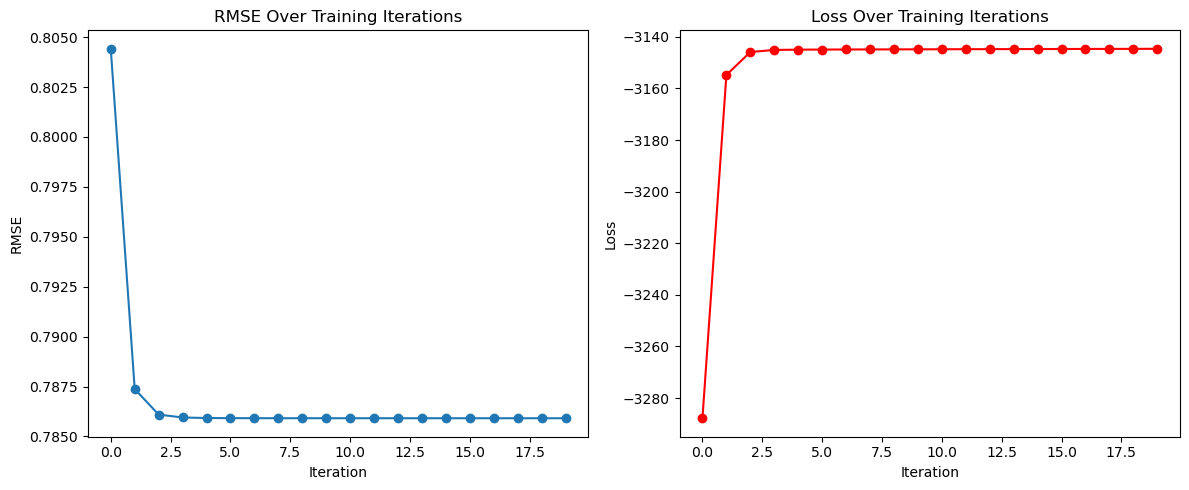

In [10]:
lambda_reg = 0.1  # Scaling factor for the error term
gamma = 0.01       # Regularization parameter
user_bias, item_bias, global_bias, losses, rmses = alternating_least_squares(indexed_user_ids, indexed_movie_ids, ratings, 20, lambda_reg, gamma)

# Plotting the RMSE over iterations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rmses, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Training Iterations')

# Plotting the Loss over iterations
plt.subplot(1, 2, 2)
plt.plot(losses, marker='o', linestyle='-', color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Training Iterations')

plt.tight_layout()
plt.show()

# User and item latent factor vectors included

In [11]:
def initialize_factors(user_ids, movie_ids, num_factors):
    unique_users = np.unique(user_ids)
    unique_movies = np.unique(movie_ids)
    user_bias = np.zeros(len(unique_users))
    item_bias = np.zeros(len(unique_movies))
    user_factors = np.random.normal(0, 0.1, (len(unique_users), num_factors))
    item_factors = np.random.normal(0, 0.1, (len(unique_movies), num_factors))
    return user_bias, item_bias, user_factors, item_factors

def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias):
    predictions = user_bias[user_ids] + item_bias[movie_ids] + np.sum(user_factors[user_ids] * item_factors[movie_ids], axis=1)
    errors = ratings - predictions
    loss = 0.5 * np.sum(errors**2)
    regularization_bias = 0.5 * gamma_bias * (np.sum(user_bias**2) + np.sum(item_bias**2))
    regularization_factors = 0.5 * gamma_latent * (np.sum(user_factors**2) + np.sum(item_factors**2))
    return lambda_reg * loss + regularization_bias + regularization_factors

def calculate_rmse(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors):
    predictions = user_bias[user_ids] + item_bias[movie_ids] + np.sum(user_factors[user_ids] * item_factors[movie_ids], axis=1)
    errors = ratings - predictions
    mse = np.mean(errors**2)  # Mean Squared Error
    return np.sqrt(mse)  # Root Mean Squared Error

In [12]:
def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    # Calculate user biases using the ALS algorithm
    for user_id in np.unique(user_ids):
        indices = np.where(user_ids == user_id)[0]
        item_indices = movie_ids[indices]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[item_indices]
        user_factor = user_factors[user_id]
        item_factors_subset = item_factors[item_indices]

        num_items = len(indices)
        dot_product = np.dot(item_factors_subset, user_factor)

        # Update equation implementation
        numerator = lambda_reg * np.sum(ratings_subset - item_bias_subset - dot_product)
        denominator = lambda_reg * num_items + gamma_bias
        user_bias[user_id] = numerator / denominator

    return user_bias

def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    # Calculate item biases using the ALS algorithm
    for movie_id in np.unique(movie_ids):
        indices = np.where(movie_ids == movie_id)[0]
        user_indices = user_ids[indices]
        ratings_subset = ratings[indices]
        user_bias_subset = user_bias[user_indices]
        item_factor = item_factors[movie_id]
        user_factors_subset = user_factors[user_indices]

        num_users = len(indices)
        dot_product = np.dot(user_factors_subset, item_factor)

        # Update equation implementation
        numerator = lambda_reg * np.sum(ratings_subset - user_bias_subset - dot_product)
        denominator = lambda_reg * num_users + gamma_bias
        item_bias[movie_id] = numerator / denominator

    return item_bias

In [13]:
def update_user_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    for user_id in np.unique(user_ids):
        indices = np.where(user_ids == user_id)[0]
        V_i = item_factors[movie_ids[indices]]
        A = lambda_reg * np.dot(V_i.T, V_i) + gamma_latent * np.eye(V_i.shape[1])
        residuals = ratings[indices] - user_bias[user_id] - item_bias[movie_ids[indices]]
        b = lambda_reg * np.sum(residuals[:, np.newaxis] * V_i, axis=0)
        user_factors[user_id] = np.linalg.solve(A, b)
    return user_factors

def update_item_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    for movie_id in np.unique(movie_ids):
        indices = np.where(movie_ids == movie_id)[0]
        U_j = user_factors[user_ids[indices]]
        A = lambda_reg * np.dot(U_j.T, U_j) + gamma_latent * np.eye(U_j.shape[1])
        residuals = ratings[indices] - user_bias[user_ids[indices]] - item_bias[movie_id]
        b = lambda_reg * np.sum(residuals[:, np.newaxis] * U_j, axis=0)
        item_factors[movie_id] = np.linalg.solve(A, b)
    return item_factors

In [14]:
def alternating_least_squares(user_ids, movie_ids, ratings, iterations=10, num_factors=10, lambda_reg=1.0, gamma_latent=0.1, gamma_bias=0.1):
    user_bias, item_bias, user_factors, item_factors = initialize_factors(user_ids, movie_ids, num_factors)
    losses = []
    rmses = []

    for iteration in range(iterations):
        user_bias = update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)
        item_bias = update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)
        
        user_factors = update_user_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)
        item_factors = update_item_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)
        
        # Compute predictions and RMSE for training set
        loss = calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
        rmse = calculate_rmse(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors)

        losses.append(loss)
        rmses.append(rmse)
        print(f"Iteration {iteration + 1}, Loss: {loss}, RMSE: {rmse}")
        
    return user_bias, item_bias, user_factors, item_factors, rmses, losses

Iteration 1, Loss: 2028.9667709047803, RMSE: 0.6065919761835861
Iteration 2, Loss: 1733.936752438701, RMSE: 0.5580145708731843
Iteration 3, Loss: 1603.8546302082989, RMSE: 0.535637737557096
Iteration 4, Loss: 1525.2083626912467, RMSE: 0.5217993802694981
Iteration 5, Loss: 1471.1035203779907, RMSE: 0.5121634519350574
Iteration 6, Loss: 1430.92397990328, RMSE: 0.5049529324012795
Iteration 7, Loss: 1399.7565793472672, RMSE: 0.49932575590630685
Iteration 8, Loss: 1374.7697984417302, RMSE: 0.4947851203671751
Iteration 9, Loss: 1354.251949141384, RMSE: 0.49103530324089917
Iteration 10, Loss: 1337.0058250282782, RMSE: 0.48786133504296064
Iteration 11, Loss: 1322.311317020749, RMSE: 0.48514162510397163
Iteration 12, Loss: 1309.7262407724959, RMSE: 0.48280843220510644
Iteration 13, Loss: 1298.8569483965225, RMSE: 0.4807892219145702
Iteration 14, Loss: 1289.3782475194012, RMSE: 0.4790214303167947
Iteration 15, Loss: 1281.0354014891204, RMSE: 0.4774583670771006
Iteration 16, Loss: 1273.6434298120

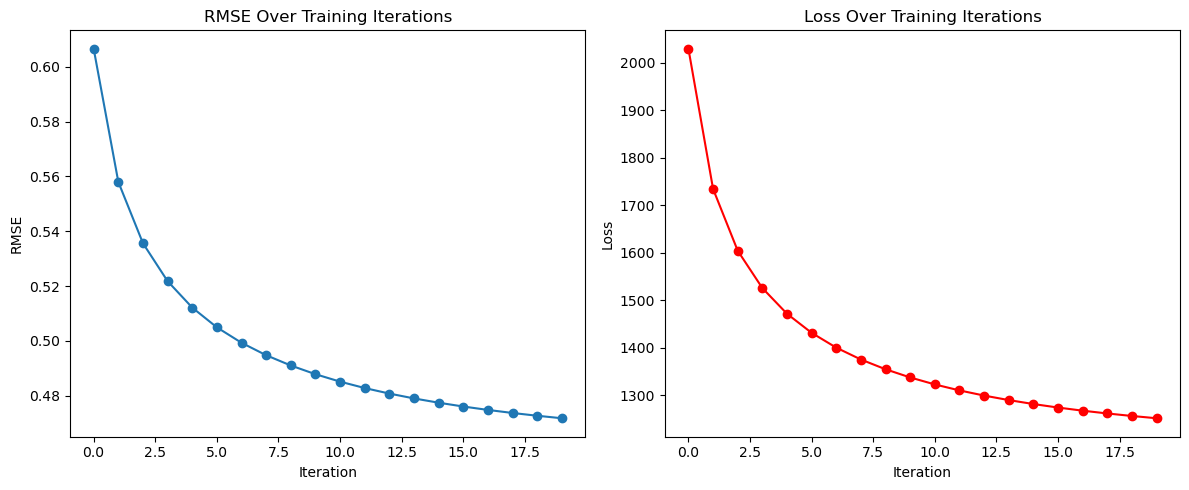

In [15]:
# Usage
iterations = 20
k = 10
lambda_reg = 0.1  # Error scaling factor
gamma_latent = 0.01       # Regularization parameter for latent factor vectors
gamma_bias = 0.01       # Regularization parameter for biases

user_bias, item_bias, user_factors, item_factors, rmses, losses = alternating_least_squares(indexed_user_ids, indexed_movie_ids, ratings, iterations, k, lambda_reg, gamma_latent, gamma_bias)

# Plotting the RMSE over iterations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rmses, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Training Iterations')

# Plotting the Loss over iterations
plt.subplot(1, 2, 2)
plt.plot(losses, marker='o', linestyle='-', color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Training Iterations')

plt.tight_layout()
plt.show()